# Assign 1 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 311503841

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

In [12]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploring The Data

In [13]:
# Get the Image Resolutions
root_path = 'chest_xray\\train\\PNEUMONIA\\'
imgs = [img.name for img in Path(root_path).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root_path+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 3883


,FileName,Size,Width,Height,Aspect Ratio
0,person1000_bacteria_2931.jpeg,"(1152, 760)",1152,760,1.52
1,person1000_virus_1681.jpeg,"(1072, 768)",1072,768,1.40
2,person1001_bacteria_2932.jpeg,"(1244, 863)",1244,863,1.44
3,person1002_bacteria_2933.jpeg,"(1242, 940)",1242,940,1.32
4,person1003_bacteria_2934.jpeg,"(1488, 1280)",1488,1280,1.16


In [14]:
print("min width:", img_meta_df["Width"].min())
print("min height:", img_meta_df["Height"].min())

min width: 384
min height: 127


Text(0, 0.5, 'Height')

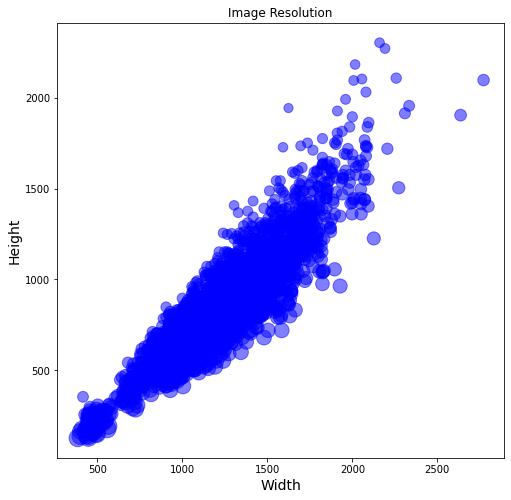

In [15]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

# Loading The Data

In [16]:
image_size=(256, 256)
train_directory = 'chest_xray/train'
test_directory = 'chest_xray/test'
seed = np.random.randint(50, dtype=int)

# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='grayscale', batch_size=32, image_size=image_size,
    shuffle=True, seed=seed, validation_split=0.15, subset='training',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='grayscale', batch_size=32, image_size=image_size, 
    shuffle=True, seed=seed, validation_split=0.15, subset='validation',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='grayscale', batch_size=32, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 5232 files belonging to 2 classes.
Using 784 files for validation.
Found 624 files belonging to 2 classes.


In [17]:
train_data

<BatchDataset shapes: ((None, 256, 256, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [18]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32, 2)


In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
train_labels = np.array([])

for x, y in train_data:
    train_labels = np.concatenate([train_labels, np.argmax(y.numpy(), axis = -1)])

val_labels =  np.array([])

for x, y in validation_data:
    val_labels = np.concatenate([val_labels, np.argmax(y.numpy(), axis = -1)])

test_labels =  np.array([])

for x, y in test_data:
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])


print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Labels Shape: (4448,)
Validation Labels Shape: (784,)
Test Labels Shape: (624,)


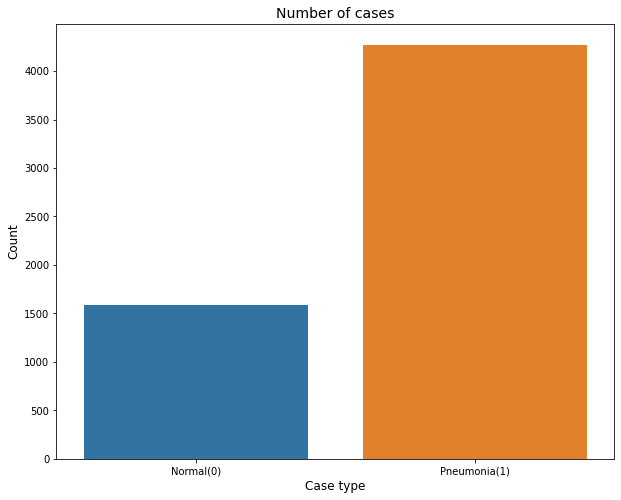

In [11]:
train_cases_count = np.unique(train_labels, return_counts=True)
val_cases_count = np.unique(val_labels, return_counts=True)
test_cases_count = np.unique(test_labels, return_counts=True)

total_cases_count = train_cases_count[1] + val_cases_count[1] + test_cases_count[1]

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=[0, 1], y=total_cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(total_cases_count)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

<h3>
As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. <br>
This situation is very normal when it comes to medical data. The data will always be imbalanced. <br>
either there will be too many normal cases or there will be too many cases with the disease.</h3>

In [12]:
COUNT_NORMAL = total_cases_count[0]
COUNT_PNEUMONIA = total_cases_count[1]
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA


print('Because of imbalanced data, the accuracy result of the test set will tend to be around:',COUNT_PNEUMONIA/(COUNT_NORMAL+COUNT_PNEUMONIA))

Because of imbalanced data, the accuracy result of the test set will tend to be around: 0.7296789617486339


# Correcting imbalanced data using weights
<h3>
Using a set of pre calculated starting weights we well try to make the model think that the normal images <br>
are more "important" than the pneumonia ones by a certain amount based on their occurrences.<br>

Moreover, we are not going to purely use the accuracy mertrics but we will use Prescision and Recall metrics.

Here's a good article explaining the difference:
[Evaluating Deep Learning Models: The Confusion Matrix, Accuracy, Precision, and Recall](https://blog.paperspace.com/deep-learning-metrics-precision-recall-accuracy/)
</h3>


<h3>
In this type of problem, recall is most significant quantity even more than accuracy and precision. <br>
Since we are having unequal number of people in both the classes , therefore we can't take accuracy as an alone metric to calculate model efficieny .<br>

precision = True Positive / (True Positive + False Positive)<br>
recall = True Positive / (True Positive + False Negative)<br>

Also precision can't be taken as alone metric and has less significance than recall in this particular dataset <br>
because we have to minimize false negative and that is in the denominator and thus finally increasing 'Recall' .<br>
False negative has to be intuitively minimized because falsely diagnosing a patient of pneumonia as not having a pneumonia <br>
is a much larger deal than falsely diagnosing a healthy person as a pneumonia patient which is our major concern . <br>
That is why we are making this model . To reduce the mistakes done by doctors accidentally .

In [13]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.69


# Basic Model (without convolution layers)

In [14]:
num_classes = 2
input_shape = (256, 256, 1)

basic_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(10, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.15),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [15]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 10)      20        
                                                                 
 dense_1 (Dense)             (None, 256, 256, 8)       88        
                                                                 
 dense_2 (Dense)             (None, 256, 256, 6)       54        
                                                                 
 flatten (Flatten)           (None, 393216)            0         
                                                                 
 dropout (Dropout)           (None, 393216)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 786434    
                                                                 
Total params: 786,596
Trainable params: 786,596
Non-trai

In [16]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [17]:
epochs = 20

callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

METRICS = ['accuracy']

basic_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

basic_history = basic_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 [==============================] - 6s 33ms/step - loss: 0.8104 - accuracy: 0.8624 - val_loss: 0.1720 - val_accuracy: 0.9362 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 [==============================] - 3s 21ms/step - loss: 0.1648 - accuracy: 0.9371 - val_loss: 0.1547 - val_accuracy: 0.9362 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 [==============================] - 3s 21ms/step - loss: 0.1347 - accuracy: 0.9485 - val_loss: 0.1822 - val_accuracy: 0.9273 - lr: 6.1413e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 [==============================] - 3s 21ms/step - loss: 0.1173 - accuracy: 0.9535 - val_loss: 0.2489 - val_accuracy: 0.9082 - lr: 3.7715e-04

Epoch 00005: LearningRateSc

In [18]:
# saving the model
basic_model.save('models/basic_model.h5')

In [19]:
# loading the model
from tensorflow.keras.models import load_model
basic_model = load_model('models/basic_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


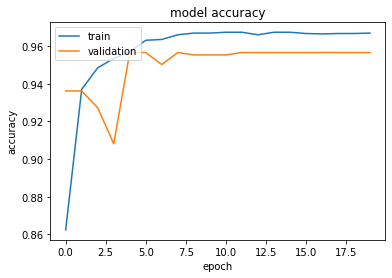

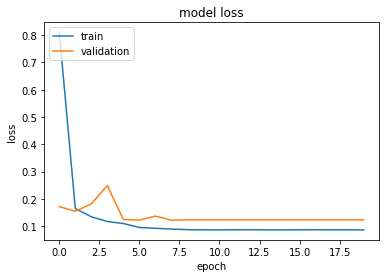

In [20]:
# list all data in history
print(basic_history.history.keys())
# summarize history for accuracy
plt.plot(basic_history.history['accuracy'])
plt.plot(basic_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(basic_history.history['loss'])
plt.plot(basic_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
loss, accuracy = basic_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 19ms/step - loss: 0.6544 - accuracy: 0.7837
Test loss: 0.6544146537780762
Test accuracy: 0.7836538553237915


In [22]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(basic_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


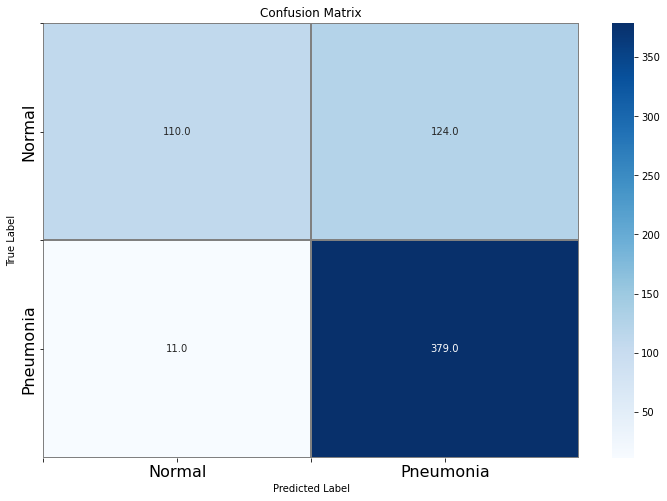

In [23]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.47      0.62       234
         1.0       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



# Advanced Model (using convolution layers)

In [25]:
num_classes = 2
input_shape = (256, 256, 1)

advanced_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(2, 2), padding='same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(2, 2), padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(50, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
) 

In [26]:
advanced_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                  

In [27]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [28]:
BATCH_SIZE = 32

EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

callbacks = [learning_rate, early_stopping]

METRICS = ['accuracy']

advanced_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

advanced_history = advanced_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 [==============================] - 8s 43ms/step - loss: 0.2750 - accuracy: 0.8775 - precision: 0.8775 - recall: 0.8775 - val_loss: 0.3408 - val_accuracy: 0.8673 - val_precision: 0.8673 - val_recall: 0.8673 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 [==============================] - 5s 39ms/step - loss: 0.1121 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - val_loss: 0.1523 - val_accuracy: 0.9426 - val_precision: 0.9426 - val_recall: 0.9426 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 [==============================] - 5s 39ms/step - loss: 0.0695 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - val_loss: 0.0872 - val_accuracy: 0.9694 - val_precision: 0.9694 - val_recall: 0.9694 - lr: 6.1413e-04

Epoch 00004: LearningRate

In [29]:
# saving the model
advanced_model.save('models/advanced_model.h5')

In [30]:
# loading the model
from tensorflow.keras.models import load_model
advanced_model = load_model('models/advanced_model.h5')

In [31]:
loss, accuracy, precision, recall = advanced_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 0s 13ms/step - loss: 1.5650 - accuracy: 0.7660 - precision: 0.7660 - recall: 0.7660
Test loss: 1.5649898052215576
Test accuracy: 0.7660256624221802
Test precision: 0.7660256624221802
Test recall: 0.7660256624221802


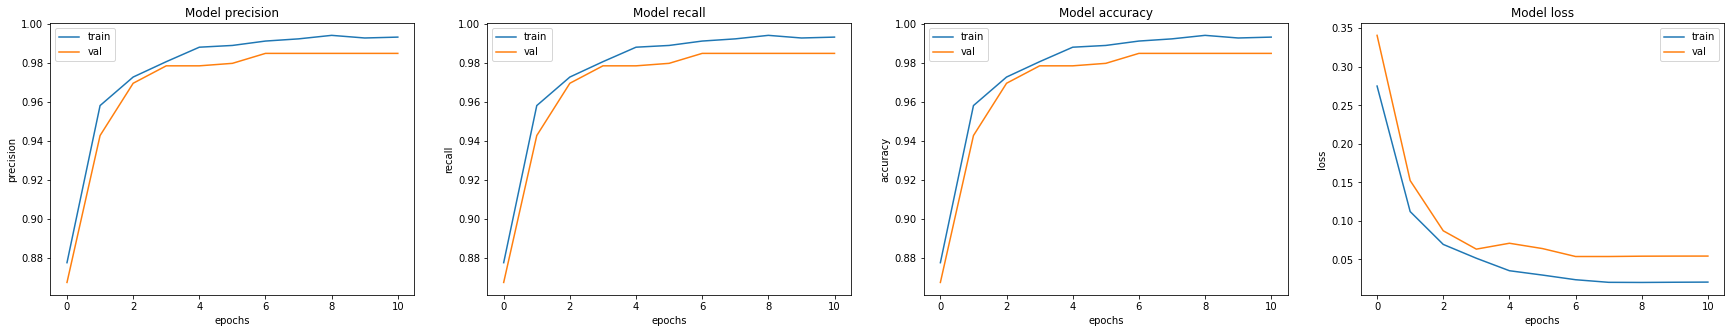

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(advanced_history.history[met])
    ax[i].plot(advanced_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(advanced_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


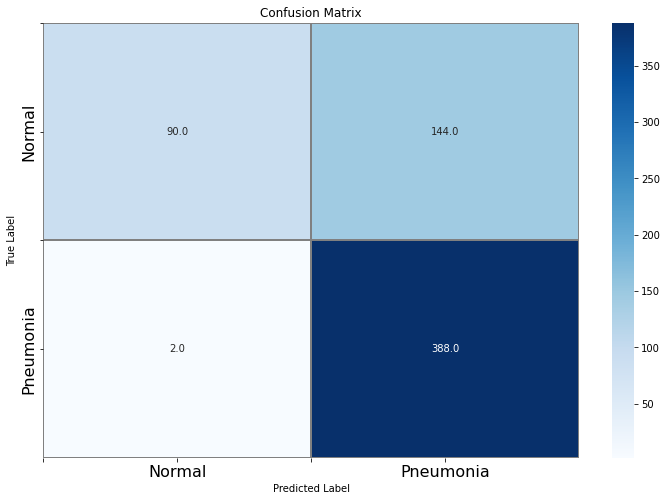

In [34]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.38      0.55       234
         1.0       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.73       624



# Data Augmentation 

In [36]:
num_classes = 2
input_shape = (256, 256, 1)

augmentation_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        # Data Augmentation
        preprocessing.RandomContrast(0.3),
        preprocessing.RandomRotation(0.18),
        preprocessing.RandomZoom(0.21),
        
        # body
        layers.BatchNormalization(),
        
        layers.Conv2D(64, kernel_size=(3,3) , strides=(1, 1) , padding = 'same' , activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3,3) , strides=(1, 1) , padding = 'same' , activation = 'relu'),
        layers.Dropout(0.2),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),

        layers.Conv2D(64, kernel_size=(3,3) , strides=(1, 1) , padding = 'same' , activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),
        layers.Dropout(0.1),
        
        layers.Conv2D(128, kernel_size=(3,3) , strides=(1, 1) , padding = 'same', activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),

        # Head
        layers.Flatten(),
        layers.Dense(units = 128, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation = 'sigmoid'),
    ]
) 

In [37]:
augmentation_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 256, 256, 1)      0         
 rast)                                                           
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 1)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 1)       0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      640       
                                                      

In [38]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [39]:
BATCH_SIZE = 64

EPOCHS = 40

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

callbacks = [learning_rate, early_stopping]

METRICS = ['accuracy']

augmentation_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

augmentation_history = augmentation_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
139/139 [==============================] - 10s 60ms/step - loss: 0.4596 - accuracy: 0.7902 - precision: 0.7816 - recall: 0.7653 - val_loss: 0.4647 - val_accuracy: 0.8890 - val_precision: 0.9000 - val_recall: 0.8724 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/40
139/139 [==============================] - 8s 55ms/step - loss: 0.2643 - accuracy: 0.8948 - precision: 0.8925 - recall: 0.8957 - val_loss: 0.2844 - val_accuracy: 0.9375 - val_precision: 0.9367 - val_recall: 0.9439 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/40
139/139 [==============================] - 8s 57ms/step - loss: 0.2293 - accuracy: 0.9103 - precision: 0.9102 - recall: 0.9074 - val_loss: 0.2034 - val_accuracy: 0.9209 - val_precision: 0.9198 - val_recall: 0.9222 - lr: 6.1413e-04

Epoch 00004: LearningRat

In [40]:
# saving the model
augmentation_model.save('models/augmentation_model.h5')

In [41]:
# loading the model
from tensorflow.keras.models import load_model
augmentation_model = load_model('models/augmentation_model.h5')

In [42]:
loss, accuracy, precision, recall = augmentation_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 17ms/step - loss: 0.2888 - accuracy: 0.8702 - precision: 0.8683 - recall: 0.8766
Test loss: 0.2888180613517761
Test accuracy: 0.870192289352417
Test precision: 0.8682539463043213
Test recall: 0.8766025900840759


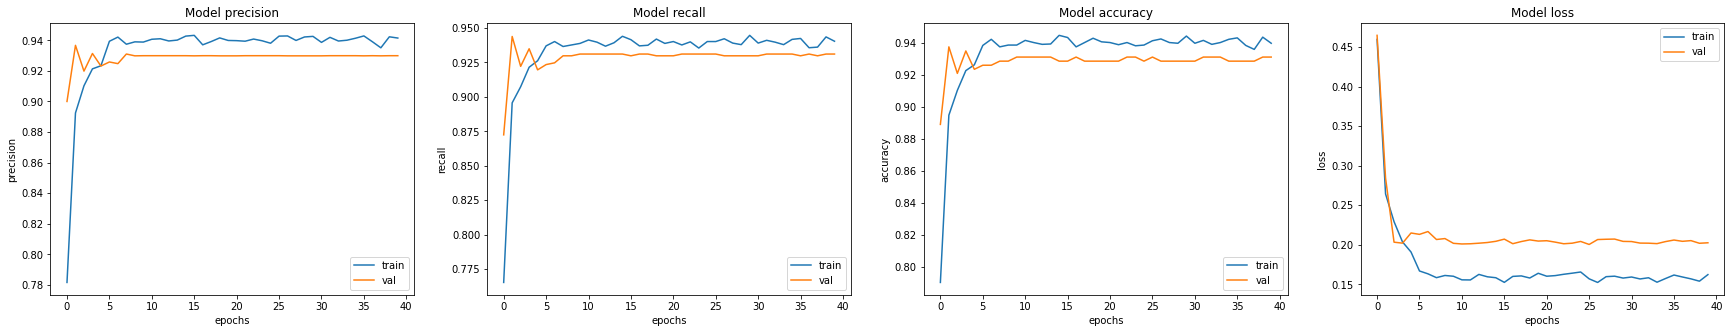

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(augmentation_history.history[met])
    ax[i].plot(augmentation_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(augmentation_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


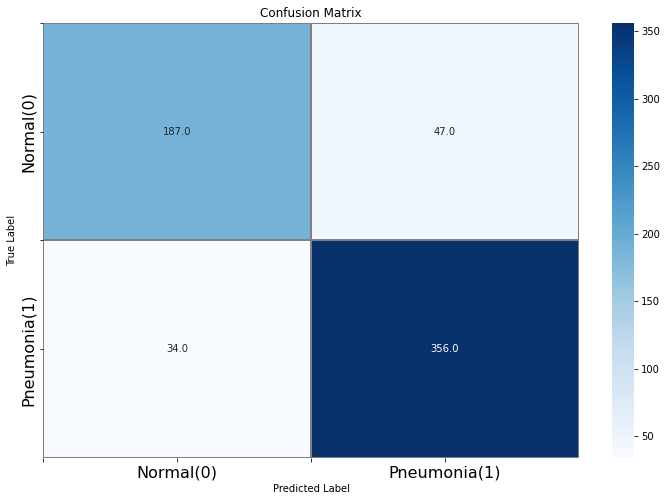

In [47]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [46]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82       234
         1.0       0.88      0.91      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624

